# GCAE implementation and visualizations
This implementation uses [GVP](https://github.com/drorlab/gvp-pytorch), developed by B Jing et al.

In [ ]:
!pip install matplotlib torch torch_geometric mdtraj tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mdtraj: filename=mdtraj-1.9.9-cp310-cp310-linux_x86_64.whl size=7547225 sha256=217075625043cce07941e150f2c85e784dac49bb6472a5e4396a3ec6fb8e4d07
  Stored in directory: /root/.cache/pip/wheels/4b/4e/d5/22b44e04aca0780281ffb43717ebb3404bc1a77cf8f345fa73
Successfully built mdtraj


In [ ]:
!git clone https://github.com/drorlab/gvp-pytorch.git

Cloning into 'gvp-pytorch'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 52 (delta 11), reused 7 (delta 7), pack-reused 34
Receiving objects: 100% (52/52), 918.43 KiB | 5.19 MiB/s, done.
Resolving deltas: 100% (19/19), done.


# IMPORTANT: in order to run ```!pip install gvp-pytorch/```  go into gvp-ptorch/setup.py and change "sklearn" to "scikit-learn" (on line 25)

# Packages

In [ ]:
!pip install gvp-pytorch/

Processing ./gvp-pytorch
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.1/270.1 kB 33.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.2 MB/s eta 0:00:00


In [ ]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import math, random, time
import torch, torch_geometric
import torch.utils.data as data
import torch.nn as nn
import gvp.data
from gvp import GVP, GVPConvLayer, LayerNorm

import mdtraj as md

from tqdm import tqdm

# Functions

In [ ]:
def create_structures(files, pdb):
    topology = md.load(pdb).topology
    start = time.time()
    structures = {}
    for file in files:
        traj = md.load_xtc(file, top=pdb)
        traj.center_coordinates()

        # grab atoms we want
        N_atoms = traj.atom_slice(topology.select("protein and name N and resn!= ACE and resn!= NME"))
        CA_atoms = traj.atom_slice(topology.select("protein and name CA and resn!= ACE and resn!= NME"))
        C_atoms = traj.atom_slice(topology.select("protein and name C and resn!= ACE and resn!= NME"))
        O_atoms = traj.atom_slice(topology.select("protein and name O and resn!= ACE and resn!= NME"))

        N_coords = N_atoms.xyz
        CA_coords = CA_atoms.xyz
        C_coords = C_atoms.xyz
        O_coords = O_atoms.xyz

        #backbone = traj.atom_slice(topology.select("protein and backbone"))
        #coords = backbone.xyz # has size (n_frames x n_atoms x 3)

        #traj_coords = coords.reshape(-1, backbone.n_atoms*3).T # has size (n_atoms*3 x n_frames)
        #print(traj_coords.shape)



        for i in range(len(traj)):
            coords = np.stack([N_coords[i,:,:], CA_coords[i,:,:], C_coords[i,:,:], O_coords[i,:,:]],1)
            #print(coords.shape)
            #coords = traj_coords[:,i]
            #coords = np.expand_dims(coords, axis=1)
            #structures.append({'coords':coords,
            #                   'name': f'{file[5:-4]}_frame{i}',
            #                   'seq': ['Q']*traj_coords.shape[0]})
            structures[f'{file[5:-4]}_frame{i}'] = {'coords': coords,
                                                    'name': f'{file[5:-4]}_frame{i}',
                                                    'seq': ['Q']*coords.shape[0]} # seq doesn't matter for now
    end = time.time()
    print("create structures took", round((end-start)/60,4), "minutes")
    return structures

In [ ]:
class LigandDataset(gvp.data.ProteinGraphDataset):
    def __init_(self, data_list,
                num_positional_embeddings=16,
                top_k=30, num_rbf=16, device="cpu"):
        for structure in data_list:
            structure['seq'] = ['Q'] * structure['coords'].shape[0]
        super(LigandDataset, self).__init__(data_list,
                                            num_positional_embeddings,
                                            top_k, num_rbf, device)

In [ ]:
class GCAE(nn.Module):
    '''
    Graph Convolutional AutoEncoder

    Takes in protein structure graphs of type `torch_geometric.data.Data`
    or `torch_geometric.data.Batch` and returns a 3D position per node of
    shape [n_nodes, 3].

    Should be used with `gvp.data.ProteinGraphDataset`, or with generators
    of `torch_geometric.data.Batch` objects with the same attributes.

    :param node_in_dim: node dimensions in input graph, should be
                        (6, 3) if using features from GVP-GNN
    :param node_h_dim: hidden node dimensions to use in intermediate layers
    :param node_in_dim: edge dimensions in input graph, should be
                        (32, 1) if using original features from GVP-GNN
    :param edge_h_dim: hidden edge dimensions to embed to before use
                       in intermediate layers
    :param num_layers: number of layers in each of the encoder
                       and decoder modules
    :param drop_rate: rate to use in all dropout layers
    '''
    def __init__(self, node_in_dim, node_h_dim,
                 edge_in_dim, edge_h_dim,
                 num_layers=3, drop_rate=0.1, node_num=66):

        super(GCAE, self).__init__()

        self.node_num = node_num

        self.W_v = nn.Sequential(
            GVP(node_in_dim, node_h_dim, activations=(None, None)),
            LayerNorm(node_h_dim)
        )
        self.W_e = nn.Sequential(
            GVP(edge_in_dim, edge_h_dim, activations=(None, None)),
            LayerNorm(edge_h_dim)
        )

        self.encoder_layers = nn.ModuleList(
                GVPConvLayer(node_h_dim, edge_h_dim, drop_rate=drop_rate)
            for _ in range(num_layers))


        self.squeeze_layer = nn.Sequential(
            nn.Linear(self.node_num*(node_h_dim[0]+node_h_dim[1]*3),1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=drop_rate),
            nn.Linear(1024, 16)
        )

        self.unsqueeze_layer = nn.Sequential(
            nn.Linear(16, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=drop_rate),
            nn.Linear(1024, self.node_num*(node_h_dim[0]+node_h_dim[1]*3))
        )


        self.decoder_layers = nn.ModuleList(
                GVPConvLayer(node_h_dim, edge_h_dim, drop_rate=drop_rate)
            for _ in range(num_layers))

        self.W_out = GVP(node_h_dim, (3, 0), activations=(None, None))


    def forward(self, h_V, edge_index, h_E):
        '''
        Forward pass to be used at train-time or test-time.

        :param h_V: tuple (s, V) of node embeddings
        :param edge_index: `torch.Tensor` of shape [2, num_edges]
        :param h_E: tuple (s, V) of edge embeddings
        :param seq: int `torch.Tensor` of shape [num_nodes]
        '''

        h_V = (h_V[0].reshape(h_V[0].shape[0]*h_V[0].shape[1],h_V[0].shape[2]),
               h_V[1].reshape(h_V[1].shape[0]*h_V[1].shape[1],h_V[1].shape[2],h_V[1].shape[3]))

        h_E = (h_E[0].reshape(h_E[0].shape[0]*h_E[0].shape[1],h_E[0].shape[2]),
               h_E[1].reshape(h_E[1].shape[0]*h_E[1].shape[1],h_E[1].shape[2],h_E[1].shape[3]))

        h_V = self.W_v(h_V)
        h_E = self.W_e(h_E)

        for layer in self.encoder_layers:
            h_V = layer(h_V, edge_index, h_E)

        encoder_embeddings = h_V

        flat_s = h_V[0].reshape(h_V[0].shape[0]//self.node_num, -1)
        flat_V = h_V[1].reshape(h_V[1].shape[0]//self.node_num, -1)
        h_V_stack = torch.cat((flat_s, flat_V),dim=1)
        h_V_stack = self.squeeze_layer(h_V_stack)

        h_V_small = torch.clone(h_V_stack)

        h_V_stack = self.unsqueeze_layer(h_V_stack)

        flat_s = h_V_stack[:,:self.node_num*encoder_embeddings[0].shape[1]]
        flat_V = h_V_stack[:,self.node_num*encoder_embeddings[0].shape[1]:]
        h_V = (flat_s.reshape(encoder_embeddings[0].shape),
               flat_V.reshape(encoder_embeddings[1].shape))


        for layer in self.decoder_layers:
            h_V = layer(h_V, edge_index, h_E)
        logits = self.W_out(h_V)

        logits = logits.reshape(-1, self.node_num, 3)
        return logits, h_V_small


In [ ]:
class GCAE2(nn.Module):
    '''
    Graph Convolutional AutoEncoder

    Takes in protein structure graphs of type `torch_geometric.data.Data`
    or `torch_geometric.data.Batch` and returns a 3D position per node of
    shape [n_nodes, 3].

    Should be used with `gvp.data.ProteinGraphDataset`, or with generators
    of `torch_geometric.data.Batch` objects with the same attributes.

    :param node_in_dim: node dimensions in input graph, should be
                        (6, 3) if using features from GVP-GNN
    :param node_h_dim: hidden node dimensions to use in intermediate layers
    :param node_in_dim: edge dimensions in input graph, should be
                        (32, 1) if using original features from GVP-GNN
    :param edge_h_dim: hidden edge dimensions to embed to before use
                       in intermediate layers
    :param num_layers: number of layers in each of the encoder
                       and decoder modules
    :param drop_rate: rate to use in all dropout layers
    '''
    def __init__(self, node_in_dim, node_h_dim,
                 edge_in_dim, edge_h_dim,
                 num_layers=3, drop_rate=0.1, node_num=66):

        super(GCAE2, self).__init__()

        self.node_num = node_num

        self.W_v = nn.Sequential(
            GVP(node_in_dim, node_h_dim, activations=(None, None)),
            LayerNorm(node_h_dim)
        )
        self.W_e = nn.Sequential(
            GVP(edge_in_dim, edge_h_dim, activations=(None, None)),
            LayerNorm(edge_h_dim)
        )

        self.encoder_layers = nn.ModuleList(
                GVPConvLayer(node_h_dim, edge_h_dim, drop_rate=drop_rate)
            for _ in range(num_layers))


        self.squeeze_layer = nn.Sequential(
            nn.Linear(self.node_num*(node_h_dim[0]+node_h_dim[1]*3),1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=drop_rate),
            nn.Linear(1024, 16)
        )

        self.unsqueeze_layer = nn.Sequential(
            nn.Linear(16, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=drop_rate),
            nn.Linear(1024, self.node_num*(node_h_dim[0]+node_h_dim[1]*3))
        )


        self.decoder_layers = nn.ModuleList(
                GVPConvLayer(node_h_dim, edge_h_dim, drop_rate=drop_rate)
            for _ in range(num_layers))

        self.W_out = GVP(node_h_dim, (3, 0), activations=(None, None))


    def forward(self, h_V, edge_index, h_E, output=None):
        '''
        Forward pass to be used at train-time or test-time.

        :param h_V: tuple (s, V) of node embeddings
        :param edge_index: `torch.Tensor` of shape [2, num_edges]
        :param h_E: tuple (s, V) of edge embeddings
        :param seq: int `torch.Tensor` of shape [num_nodes]
        '''

        h_V = (h_V[0].reshape(h_V[0].shape[0]*h_V[0].shape[1],h_V[0].shape[2]),
               h_V[1].reshape(h_V[1].shape[0]*h_V[1].shape[1],h_V[1].shape[2],h_V[1].shape[3]))

        h_E = (h_E[0].reshape(h_E[0].shape[0]*h_E[0].shape[1],h_E[0].shape[2]),
               h_E[1].reshape(h_E[1].shape[0]*h_E[1].shape[1],h_E[1].shape[2],h_E[1].shape[3]))

        h_V = self.W_v(h_V)
        h_E = self.W_e(h_E)

        for layer in self.encoder_layers:
            h_V = layer(h_V, edge_index, h_E)

        encoder_embeddings = h_V

        flat_s = h_V[0].reshape(h_V[0].shape[0]//self.node_num, -1)
        flat_V = h_V[1].reshape(h_V[1].shape[0]//self.node_num, -1)
        h_V_stack = torch.cat((flat_s, flat_V),dim=1)
        h_V_stack = self.squeeze_layer(h_V_stack)

        h_V_small = torch.clone(h_V_stack)

        if output is not None:
          assert(h_V_stack.shape == output.shape)
          h_V_stack = output.float()

        h_V_stack = self.unsqueeze_layer(h_V_stack)

        flat_s = h_V_stack[:,:self.node_num*encoder_embeddings[0].shape[1]]
        flat_V = h_V_stack[:,self.node_num*encoder_embeddings[0].shape[1]:]
        h_V = (flat_s.reshape(encoder_embeddings[0].shape),
               flat_V.reshape(encoder_embeddings[1].shape))


        for layer in self.decoder_layers:
            h_V = layer(h_V, edge_index, h_E)
        logits = self.W_out(h_V)

        logits = logits.reshape(-1, self.node_num, 3)
        return logits, h_V_small

In [ ]:
def train_gnn(model_dir, model, train_structures, n_epoch=20):
    if torch.cuda.is_available():
        device = torch.device('cuda')
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    train_dataset = LigandDataset(train_structures)

    train_dataloader = torch_geometric.loader.DenseDataLoader(train_dataset,
                                                              batch_size=256,
                                                              shuffle=True,
                                                              num_workers=2)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    losses = torch.zeros(n_epoch,1)
    #num_trained = len(glob.glob(os.path.join(model_dir,'epoch-*.pt')))
    # if we haven't started training yet, n_epochs will go from 0 -> n_epoch
    #n_epochs = list(range(num_trained, num_trained+n_epoch))
    n_epochs = list(range(0,n_epoch))
    for epoch in n_epochs:
        batch_losses = []
        start = time.time()
        for i, batch in enumerate(tqdm(train_dataloader)):
            optimizer.zero_grad()
            batch = batch.to(device)

            nodes = (batch.node_s, batch.node_v)
            edges = (batch.edge_s, batch.edge_v)
            GT = batch.x

            edge_index = batch.edge_index.permute([1,0,2])
            edge_index = edge_index.reshape(2, -1)

            pred,latent = model(nodes, edge_index, edges)

            # make it so if close in latent space it is close in tica space
            # so minimize norm of (pairwise dist in latent minus pairwise dist in tica)
            loss = ((GT - pred) ** 2).mean()

            #if i % 100 == 0:
            #  print("batch", i, "loss", loss.item())

            batch_losses.append(loss.item())

            loss.backward()
            optimizer.step()

            #clear_output(wait=True)
            #print(f'EPOCH {epoch} BATCH {i} TRAIN loss: {loss:.4f}')

        path = os.path.join(model_dir, 'epoch-{}.pt'.format(epoch))
        torch.save(model.state_dict(), path)





        # save avg loss value over batch for each epoch
        losses[epoch] = np.mean(batch_losses)
        torch.save(losses, os.path.join(model_dir, 'losses.pt'))

        end = time.time()
        t = round((end-start)/60,4)
        print(f'----Epoch {epoch} | TRAIN loss: {losses[epoch, 0]} | Elapsed time: {t} minutes----')

    view_output(model_dir, GT, pred, prefix='train_output_')
    plot_loss(model_dir)

    return model

In [ ]:
def run_inference(model, model_dir, test_structures, batch_size=256):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #test_structures = torch.load(os.path.join(model_dir,structures))
    test_dataset = gvp.data.ProteinGraphDataset(test_structures)
    test_dataloader = torch_geometric.loader.DenseDataLoader(test_dataset,
                                                             batch_size=batch_size,
                                                             shuffle=False,
                                                             num_workers=2)

    model.eval()
    latents, preds, GTs = ([] for i in range(3))
    losses=[]
    for i, batch in enumerate(tqdm(test_dataloader)):
        batch = batch.to(device)
        nodes = (batch.node_s, batch.node_v)
        edges = (batch.edge_s, batch.edge_v)
        GT = batch.x
        edge_index = batch.edge_index.permute([1,0,2])
        edge_index = edge_index.reshape(2, -1)

        pred, latent = model(nodes, edge_index, edges)

        loss = ((GT - pred) ** 2).mean()

        if i % 100 == 0:
          print("batch", i, "loss", loss.item())
        losses.append(loss.item())


        GTs.extend(GT.cpu().detach().numpy())
        latents.extend(latent.cpu().detach().numpy())
        preds.extend(pred.cpu().detach().numpy())
    print("TEST LOSS: ", np.mean(losses))
    torch.save(GTs, os.path.join(model_dir, 'inference_GTs.pt'))
    torch.save(latents, os.path.join(model_dir, 'inference_latents.pt'))
    torch.save(preds, os.path.join(model_dir, 'inference_preds.pt'))
    view_output(model_dir, GT, pred, prefix='test_output_')
    return latents, preds


In [ ]:
def view_output(model_dir, GT, pred, prefix=''):
    gt_coords = np.squeeze(GT.cpu().detach().numpy())
    pred_coords = np.squeeze(pred.cpu().detach().numpy())
    print(pred_coords.shape)
    gt_coords = gt_coords.reshape(-1,3)
    pred_coords = pred_coords.reshape(-1,3)
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(gt_coords[:,0], gt_coords[:,1], gt_coords[:,2])
    ax.scatter(pred_coords[:,0], pred_coords[:,1], pred_coords[:,2])
    fig.savefig(os.path.join(model_dir,prefix+"gnn_pred_and_GT.png"))

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(gt_coords[:,0]-pred_coords[:,0],
            gt_coords[:,1]-pred_coords[:,1],
            gt_coords[:,2]-pred_coords[:,2])
    fig.savefig(os.path.join(model_dir,prefix+"gnn_GT_-_pred.png"))
    return

def plot_loss(model_dir, prefix=''):
    losses = torch.load(os.path.join(model_dir, prefix+'losses.pt'))
    fig, ax = plt.subplots()
    loss = ax.plot(range(0,losses.shape[0]), losses,'-.')
    fig.title('Loss')
    #ax.legend(loss, (f'loss1 + {weight}*loss2', 'loss1', 'loss2'))
    print("COMBINED LOSS: ", losses)
    fig.savefig(os.path.join(model_dir,'loss.png'))

In [ ]:
def random_seed(seed=42, rank=0):
    torch.manual_seed(seed + rank)
    np.random.seed(seed + rank)
    random.seed(seed + rank)

# Get train/test structures

In [ ]:
seed = 7
test_frac = 0.2
train_drop = 0

random_seed(seed=seed)

In [ ]:
pdb = 'data/fs-peptide.pdb'
files = [f'data/trajectory-{i}.xtc' for i in range(1,29)]
np.random.seed(seed)
train_files = np.random.choice(files, size=int(len(files)* (1-test_frac)), replace=False)
test_files = np.setdiff1d(files, train_files)
train_files = np.random.choice(train_files, size=int(len(train_files)* (1 - train_drop)), replace=False)

train_structures = create_structures(train_files, pdb)
train_struct = list(train_structures.values())
test_structures = create_structures(test_files, pdb)
test_struct = list(test_structures.values())

create structures took 0.3911 minutes
create structures took 0.1539 minutes


In [ ]:
print(test_files)
print(train_files)

['data/trajectory-16.xtc' 'data/trajectory-20.xtc'
 'data/trajectory-23.xtc' 'data/trajectory-26.xtc' 'data/trajectory-4.xtc'
 'data/trajectory-5.xtc']
['data/trajectory-15.xtc' 'data/trajectory-27.xtc'
 'data/trajectory-22.xtc' 'data/trajectory-17.xtc'
 'data/trajectory-25.xtc' 'data/trajectory-11.xtc'
 'data/trajectory-13.xtc' 'data/trajectory-10.xtc' 'data/trajectory-8.xtc'
 'data/trajectory-28.xtc' 'data/trajectory-19.xtc' 'data/trajectory-1.xtc'
 'data/trajectory-6.xtc' 'data/trajectory-24.xtc' 'data/trajectory-9.xtc'
 'data/trajectory-21.xtc' 'data/trajectory-18.xtc'
 'data/trajectory-14.xtc' 'data/trajectory-7.xtc' 'data/trajectory-12.xtc'
 'data/trajectory-2.xtc' 'data/trajectory-3.xtc']


In [ ]:
model_dir = './gnn_model/'


if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")


node_h_dim = (100, 16)
edge_h_dim = (32, 1)
node_in_dim = (6, 3) #node dimensions in input graph, should be (6, 3) if using features from GVP-GNN
edge_in_dim = (32, 1) #edge dimensions in input graph should be (32, 1) if using original features from GVP-GNN
model = GCAE(node_in_dim, node_h_dim, edge_in_dim, edge_h_dim, node_num=21).to(device)


# TRAIN

100%|██████████| 860/860 [05:50<00:00,  2.45it/s]


----Epoch 0 | TRAIN loss: 0.032232616096735 | Elapsed time: 5.8427 minutes----


100%|██████████| 860/860 [05:53<00:00,  2.43it/s]


----Epoch 1 | TRAIN loss: 0.007833398878574371 | Elapsed time: 5.8984 minutes----


100%|██████████| 860/860 [05:53<00:00,  2.43it/s]


----Epoch 2 | TRAIN loss: 0.006216558162122965 | Elapsed time: 5.9007 minutes----


100%|██████████| 860/860 [05:57<00:00,  2.41it/s]


----Epoch 3 | TRAIN loss: 0.005436430685222149 | Elapsed time: 5.9523 minutes----


100%|██████████| 860/860 [05:56<00:00,  2.41it/s]


----Epoch 4 | TRAIN loss: 0.004940483253449202 | Elapsed time: 5.9428 minutes----


100%|██████████| 860/860 [05:54<00:00,  2.43it/s]


----Epoch 5 | TRAIN loss: 0.004580938257277012 | Elapsed time: 5.9053 minutes----


100%|██████████| 860/860 [05:55<00:00,  2.42it/s]


----Epoch 6 | TRAIN loss: 0.004308251664042473 | Elapsed time: 5.9258 minutes----


100%|██████████| 860/860 [05:50<00:00,  2.45it/s]


----Epoch 7 | TRAIN loss: 0.004088300745934248 | Elapsed time: 5.8399 minutes----


100%|██████████| 860/860 [05:51<00:00,  2.45it/s]


----Epoch 8 | TRAIN loss: 0.0038981116376817226 | Elapsed time: 5.8559 minutes----


100%|██████████| 860/860 [05:52<00:00,  2.44it/s]


----Epoch 9 | TRAIN loss: 0.0037418429274111986 | Elapsed time: 5.8756 minutes----


100%|██████████| 860/860 [05:50<00:00,  2.46it/s]


----Epoch 10 | TRAIN loss: 0.0036204911302775145 | Elapsed time: 5.8362 minutes----


100%|██████████| 860/860 [05:52<00:00,  2.44it/s]


----Epoch 11 | TRAIN loss: 0.0034924903884530067 | Elapsed time: 5.8787 minutes----


100%|██████████| 860/860 [05:52<00:00,  2.44it/s]


----Epoch 12 | TRAIN loss: 0.003392679151147604 | Elapsed time: 5.8709 minutes----


100%|██████████| 860/860 [05:52<00:00,  2.44it/s]


----Epoch 13 | TRAIN loss: 0.003302563214674592 | Elapsed time: 5.8764 minutes----


100%|██████████| 860/860 [06:10<00:00,  2.32it/s]


----Epoch 14 | TRAIN loss: 0.0032231060322374105 | Elapsed time: 6.1717 minutes----


100%|██████████| 860/860 [06:03<00:00,  2.36it/s]


----Epoch 15 | TRAIN loss: 0.003155685495585203 | Elapsed time: 6.0625 minutes----


100%|██████████| 860/860 [05:52<00:00,  2.44it/s]


----Epoch 16 | TRAIN loss: 0.003091843333095312 | Elapsed time: 5.8753 minutes----


100%|██████████| 860/860 [05:50<00:00,  2.45it/s]


----Epoch 17 | TRAIN loss: 0.0030341986566781998 | Elapsed time: 5.8488 minutes----


100%|██████████| 860/860 [05:55<00:00,  2.42it/s]


----Epoch 18 | TRAIN loss: 0.0029844322707504034 | Elapsed time: 5.9298 minutes----


100%|██████████| 860/860 [05:53<00:00,  2.44it/s]


----Epoch 19 | TRAIN loss: 0.0029385422822088003 | Elapsed time: 5.8856 minutes----
(96, 21, 3)


AttributeError: ignored

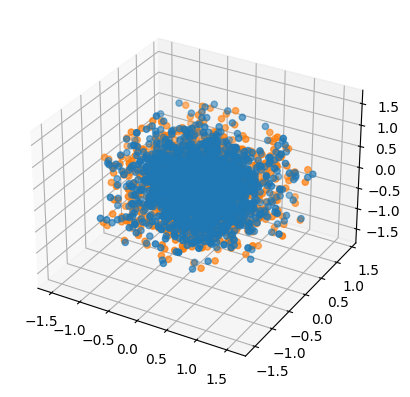

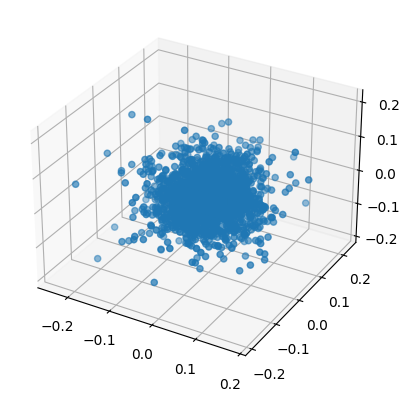

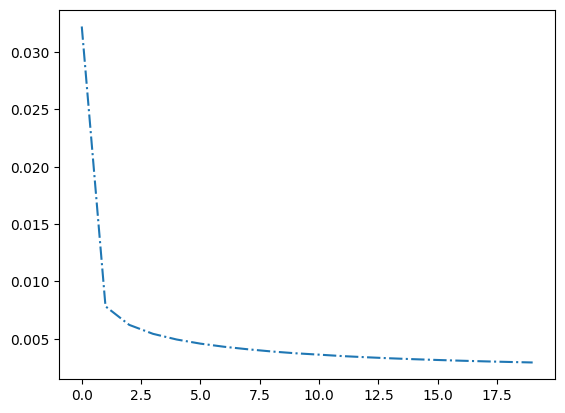

In [ ]:


model = train_gnn(model_dir, model, train_struct)


# Train further

load in a starting model and train more epochs

In [ ]:
model.load_state_dict(torch.load(os.path.join(model_dir,'epoch-7.pt'), map_location=torch.device('cpu')))

train_dataset = LigandDataset(train_struct)

train_dataloader = torch_geometric.loader.DenseDataLoader(train_dataset,
                                                          batch_size=256,
                                                          shuffle=True,
                                                          num_workers=4)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epoch = 20

losses = torch.zeros(n_epoch,1)
#num_trained = len(glob.glob(os.path.join(model_dir,'epoch-*.pt')))
# if we haven't started training yet, n_epochs will go from 0 -> n_epoch
n_epochs = list(range(8, 8+n_epoch))
#n_epochs = list(range(0,n_epoch))
for epoch in n_epochs:
    batch_losses = []
    start = time.time()
    for i, batch in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()
        batch = batch.to(device)

        nodes = (batch.node_s, batch.node_v)
        edges = (batch.edge_s, batch.edge_v)
        GT = batch.x

        edge_index = batch.edge_index.permute([1,0,2])
        edge_index = edge_index.reshape(2, -1)

        pred,latent = model(nodes, edge_index, edges)

        # make it so if close in latent space it is close in tica space
        # so minimize norm of (pairwise dist in latent minus pairwise dist in tica)
        loss = ((GT - pred) ** 2).mean()

        if i % 100 == 0:
          print("batch", i, "loss", loss.item())

        batch_losses.append(loss.item())

        loss.backward()
        optimizer.step()

        #clear_output(wait=True)
        #print(f'EPOCH {epoch} BATCH {i} TRAIN loss: {loss:.4f}')

    path = os.path.join(model_dir, 'epoch-{}.pt'.format(epoch))
    torch.save(model.state_dict(), path)





    # save avg loss value over batch for each epoch
    losses[epoch] = np.mean(batch_losses)
    torch.save(losses, os.path.join(model_dir, 'losses.pt'))

    end = time.time()
    t = round((end-start)/60,4)
    print(f'----Epoch {epoch} | TRAIN loss: {losses[epoch, 0]} | Elapsed time: {t} minutes----')






# Load Model

In [ ]:
model.load_state_dict(torch.load(os.path.join(model_dir,'epoch-17.pt'))) #, map_location=torch.device('cpu')))


<All keys matched successfully>

# Get embeddings
get train/test GTs, predictions, and latents

  0%|          | 1/860 [00:00<14:17,  1.00it/s]

batch 0 loss 0.0031122807413339615


 12%|█▏        | 101/860 [00:39<03:47,  3.33it/s]

batch 100 loss 0.002287378301844001


 23%|██▎       | 201/860 [01:19<04:16,  2.57it/s]

batch 200 loss 0.0030074571259319782


 35%|███▌      | 301/860 [01:59<02:49,  3.31it/s]

batch 300 loss 0.0031046306248754263


 47%|████▋     | 402/860 [02:40<02:51,  2.66it/s]

batch 400 loss 0.0032753387931734324


 58%|█████▊    | 501/860 [03:20<01:56,  3.09it/s]

batch 500 loss 0.0028419995214790106


 70%|███████   | 602/860 [04:01<01:43,  2.50it/s]

batch 600 loss 0.003392585786059499


 82%|████████▏ | 702/860 [04:39<00:46,  3.40it/s]

batch 700 loss 0.00306023471057415


 93%|█████████▎| 802/860 [05:19<00:27,  2.07it/s]

batch 800 loss 0.002099181991070509


100%|██████████| 860/860 [05:42<00:00,  2.51it/s]


TRAIN LOSS:  0.0030346799153173993


  1%|          | 2/235 [00:01<02:15,  1.73it/s]

batch 0 loss 0.009749522432684898


 43%|████▎     | 102/235 [00:43<00:40,  3.30it/s]

batch 100 loss 0.028241939842700958


 86%|████████▌ | 202/235 [01:24<00:10,  3.19it/s]

batch 200 loss 0.02946900762617588


100%|██████████| 235/235 [01:36<00:00,  2.43it/s]


TEST LOSS:  0.02070079747627073
(96, 21, 3)


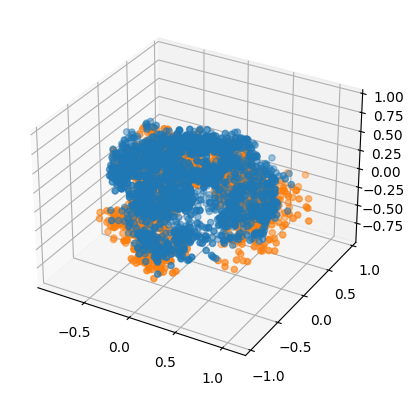

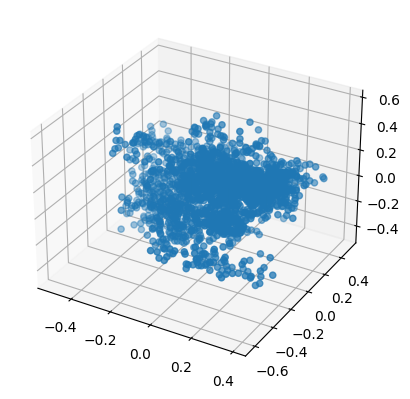

In [ ]:


train_dataset = LigandDataset(train_struct)

train_dataloader = torch_geometric.loader.DenseDataLoader(train_dataset,
                                                              batch_size=256,
                                                              shuffle=False,
                                                              num_workers=2)
latents, preds, GTs = ([] for i in range(3))
losses=[]
for i, batch in enumerate(tqdm(train_dataloader)):
      batch = batch.to(device)
      nodes = (batch.node_s, batch.node_v)
      edges = (batch.edge_s, batch.edge_v)
      GT = batch.x
      edge_index = batch.edge_index.permute([1,0,2])
      edge_index = edge_index.reshape(2, -1)

      pred, latent = model(nodes, edge_index, edges)

      loss = ((GT - pred) ** 2).mean()

      if i % 100 == 0:
        print("batch", i, "loss", loss.item())
      losses.append(loss.item())


      GTs.extend(GT.cpu().detach().numpy())
      latents.extend(latent.cpu().detach().numpy())
      preds.extend(pred.cpu().detach().numpy())
print("TRAIN LOSS: ", np.mean(losses))
torch.save(GTs, os.path.join(model_dir, 'train_GTs.pt'))
torch.save(latents, os.path.join(model_dir, 'train_latents.pt'))
torch.save(preds, os.path.join(model_dir, 'train_preds.pt'))
#view_output(model_dir, GT, pred, prefix='test_output_')

test_dataset = LigandDataset(test_struct)
test_dataloader = torch_geometric.loader.DenseDataLoader(test_dataset,
                                                             batch_size=256,
                                                             shuffle=False,
                                                             num_workers=2)

model.eval()
latents, preds, GTs = ([] for i in range(3))
losses=[]
for i, batch in enumerate(tqdm(test_dataloader)):
  batch = batch.to(device)
  nodes = (batch.node_s, batch.node_v)
  edges = (batch.edge_s, batch.edge_v)
  GT = batch.x
  edge_index = batch.edge_index.permute([1,0,2])
  edge_index = edge_index.reshape(2, -1)

  pred, latent = model(nodes, edge_index, edges)

  loss = ((GT - pred) ** 2).mean()

  if i % 100 == 0:
    print("batch", i, "loss", loss.item())
  losses.append(loss.item())


  GTs.extend(GT.cpu().detach().numpy())
  latents.extend(latent.cpu().detach().numpy())
  preds.extend(pred.cpu().detach().numpy())
print("TEST LOSS: ", np.mean(losses))
torch.save(GTs, os.path.join(model_dir, 'test_GTs.pt'))
torch.save(latents, os.path.join(model_dir, 'test_latents.pt'))
torch.save(preds, os.path.join(model_dir, 'test_preds.pt'))
view_output(model_dir, GT, pred, prefix='test_output_')













# Decode output for test

In [ ]:
test_pred = torch.load('non_weightedtest_preds_199.pt')
test_pred = test_pred.reshape(-1,16)

In [ ]:
test_pred.shape

(59940, 16)

In [ ]:
test_GTs = np.array(torch.load('gnn_model/test_GTs.pt'))
print("TEST GTs shape: ", test_GTs.shape)

test_GTs_reshape = test_GTs.reshape(-1, 10000, 21, 3)
print("thus GTs: ", test_GTs_reshape.shape)
test_GTs_reshape = test_GTs.reshape(-1, 1000, 21,3)
print("thus GTs: ", test_GTs_reshape.shape)


X_gts = test_GTs_reshape[:,:-1,:,:]

y_gts = test_GTs_reshape[:,1:,:,:]
print(X_gts.shape)
print(y_gts.shape)

y_gts = y_gts.reshape(-1, 21,3)
print(y_gts.shape)


TEST GTs shape:  (60000, 21, 3)
thus GTs:  (6, 10000, 21, 3)
thus GTs:  (60, 1000, 21, 3)
(60, 999, 21, 3)
(60, 999, 21, 3)
(59940, 21, 3)


In [ ]:
new_test_struct = []
for i in range(60*999):
  coords = test_struct[i+1]['coords']
  name = test_struct[i+1]['name']
  seq = test_struct[i+1]['seq']
  new_test_struct.append({'coords':coords,
                          'name':name,
                          'seq':seq})


In [ ]:
output=torch.tensor(test_pred).to(device)

In [ ]:
test_decode_dataset = LigandDataset(new_test_struct)
test_decode_dataloader = torch_geometric.loader.DenseDataLoader(test_decode_dataset,
                                                                batch_size=256,
                                                                shuffle=False,
                                                                num_workers=2)
model = GCAE2(node_in_dim, node_h_dim, edge_in_dim, edge_h_dim, node_num=21).to(device)
model.load_state_dict(torch.load('gnn_model/epoch-17.pt'))
output_coords = []
for i, batch in enumerate(tqdm(test_decode_dataloader)):
    batch = batch.to(device)
    if i != 234:
      batch_output = output[i*256:i*256+256,:]
    else:
      batch_output = output[i*256:, :]
    nodes = (batch.node_s, batch.node_v)
    edges = (batch.edge_s, batch.edge_v)
    GT = batch.x

    edge_index = batch.edge_index.permute([1,0,2])
    edge_index = edge_index.reshape(2, -1)

    with torch.no_grad():
        decoded,latent = model(nodes, edge_index, edges, batch_output)

    output_coords.extend(decoded.cpu().detach().numpy())



100%|██████████| 235/235 [01:30<00:00,  2.60it/s]


In [ ]:
output_coords = torch.tensor(output_coords)
print(output_coords.shape)

torch.save(output_coords, 'test_pred_decoded.pt')

torch.Size([59940, 21, 3])


<ipython-input-25-00dc2c3cfce4>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  output_coords = torch.tensor(output_coords)


In [ ]:
test_preds_decoded = np.array(output_coords)

# Calc loss on GNN encode -> transformer -> GNN decode

In [ ]:
test_preds_decoded = np.array(torch.load('gnn_model/test_pred_decoded.pt'))

In [ ]:
# this block is assuming that test_preds_decoded and
#     y_gts are in memory and are shaped (60*999, 21, 3)
assert(y_gts.shape == test_preds_decoded.shape)
losses = []
for i in range(60*999):
  losses.append((((y_gts[i,:,:] - test_preds_decoded[i,:,:])**2).mean()).item())

print("LOSSES: ", np.mean(losses), np.min(losses), np.max(losses))


print(((y_gts - test_preds_decoded)**2).mean())

LOSSES:  0.044710039708701674 0.00210701790638268 0.12514808773994446
0.04471002


In [ ]:
10*np.sqrt(np.mean(losses))

2.114474868819719

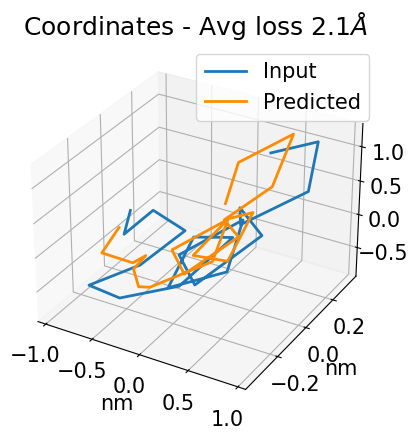

In [ ]:

i = 200#14319 #43328#, 35739, 14319 46004
example = np.array(test_preds_decoded[i,:,:])
test = y_gts[i,:,:]
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
test = y_gts[i,:,:]
ax.plot(test[:,0],
        test[:,1],
        test[:,2],lw=2, label='Input')
ax.plot(example[:,0],
        example[:,1],
        example[:,2], c='darkorange', lw=2, label='Predicted')


plt.title("Coordinates - Avg loss 2.1$\AA$")
plt.xlabel('nm')
plt.ylabel('nm')

ax.legend()
fig.savefig('GNN_pred.png')

# Visualize output of GCAE itself


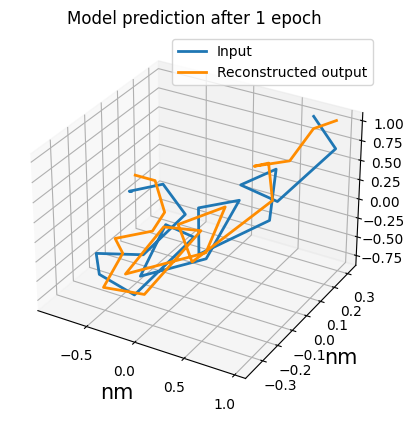

In [ ]:
GTs = np.array(torch.load('gnn_model/epoch0test_GTs.pt'))
preds = np.array(torch.load('gnn_model/epoch0test_preds.pt'))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
i = 210
ax.plot(GTs[i,:,0],
        GTs[i,:,1],
        GTs[i,:,2], lw=2, label='Input')
ax.plot(preds[i,:,0],
        preds[i,:,1],
        preds[i,:,2],lw=2, c='darkorange', label='Reconstructed output')
plt.title("Model prediction after 1 epoch")
ax.legend()
plt.xlabel('nm', fontsize=15)
plt.ylabel('nm', fontsize=15)
#plt.show()
plt.savefig('gnn_model-1.png')

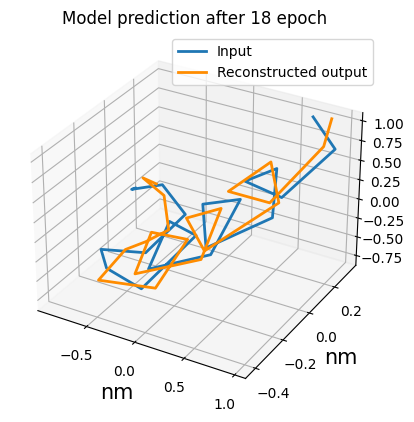

In [ ]:
GTs = np.array(torch.load('gnn_model/epoch17test_GTs.pt'))
preds = np.array(torch.load('gnn_model/epoch17test_preds.pt'))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(GTs[i,:,0],
        GTs[i,:,1],
        GTs[i,:,2], lw=2, label='Input')
ax.plot(preds[i,:,0],
        preds[i,:,1],
        preds[i,:,2],lw=2, c='darkorange', label='Reconstructed output')
plt.title("Model prediction after 18 epoch")
ax.legend()
plt.xlabel('nm', fontsize=15)
plt.ylabel('nm', fontsize=15)
#plt.show()
plt.savefig('gnn_model-17.png')

In [ ]:
((GTs - preds)**2).mean()

0.016727446

In [ ]:
np.sqrt(((GTs - preds)**2).mean())*10

1.4373809099197388

# Visualize output of regularized model

In [ ]:
import matplotlib
font = {'family': 'sans-serif', 'weight':'normal', 'size'   : 15}

matplotlib.rc('font', **font)

In [ ]:

reg_autoreg_pred = np.array(torch.load('REGULARIZEDtest_autoregressive_preds_9.pt'))
print(reg_autoreg_pred.shape)
reg_autoreg_pred = reg_autoreg_pred.reshape(-1,88,3)

print(reg_autoreg_pred.shape)
reg_autoreg_pred = reg_autoreg_pred[:, 2:-2 ,:]
print(reg_autoreg_pred.shape)

FileNotFoundError: ignored

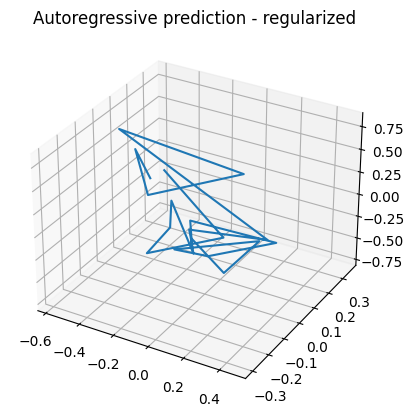

In [ ]:


i_s = [4*i+1 for i in range(0,84//4)]
j = 12345
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(reg_autoreg_pred[j,i_s,0],
        reg_autoreg_pred[j,i_s,1],
        reg_autoreg_pred[j,i_s,2])
plt.title("Autoregressive prediction - regularized")
fig.savefig('reg_autoreg_plot.png')
plt.show()

In [ ]:
import mdtraj as md

<mdtraj.Trajectory with 1 frames, 88 atoms, 23 residues, without unitcells>
[3, 7, 11, 15, 19, 23, 27, 31, 35, 39, 43, 47, 51, 55, 59, 63, 67, 71, 75, 79, 83]
<mdtraj.Trajectory with 1 frames, 88 atoms, 23 residues, without unitcells>
(21, 4, 3)
(1, 21, 3)


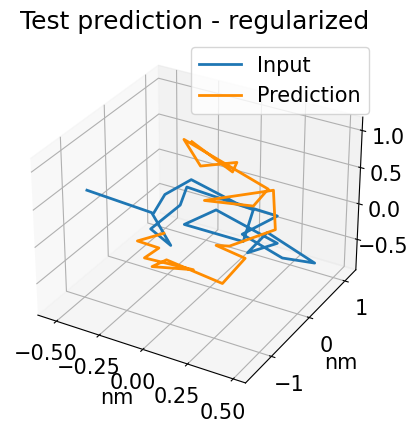

In [ ]:
topology = md.load('data/fs-peptide.pdb').topology
#topology = topology.atom_slice(topology.select("protein and backbone"))
traj = md.load('gnn_model/OUTPUT_BACKBONE_test_2.pdb')#, top='data/fs-peptide.pdb')
print(traj)
i_s = [4*i+3 for i in range(84//4)]
print(i_s)
CA_atoms = traj.atom_slice(i_s)
CA_coords = CA_atoms.xyz

traj2 = md.load('gnn_model/TEST_BACKBONE-1.pdb')
print(traj2)
CA_t_coords = traj2.xyz

coords = test_struct[0]['coords']
print(coords.shape)

i = np.argmin(((CA_coords[0,:,:] - coords[:,1,:])**2).mean())

#traj = traj[12345]
#topology = md.load('data/fs-peptide.pdb').topology

#CA_atoms = traj.atom_slice(topology.select("protein and name CA"))
#print(len(CA_atoms))
#CA_coords = CA_atoms.xyz
print(CA_coords.shape)
j=0
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(coords[:,1,0],
        coords[:,1,1],
        coords[:,1,2], lw=2, label='Input')
#ax.plot(CA_t_coords[j,i_s,0],
#        CA_t_coords[j,i_s,1],
#        CA_t_coords[j,i_s,2], lw=2,  label='Input')
ax.plot(CA_coords[j,:,0],
        CA_coords[j,:,1],
        CA_coords[j,:,2], lw=2, c='darkorange', label='Prediction')
plt.title("Test prediction - regularized")

plt.xlabel("nm")
plt.ylabel("nm")
ax.legend()
fig.savefig('test_reg_plot.png')
plt.show()

# Visualize output of non-regularized model

(60, 999, 264)
(59940, 88, 3)
(59940, 84, 3)
(21, 4, 3)


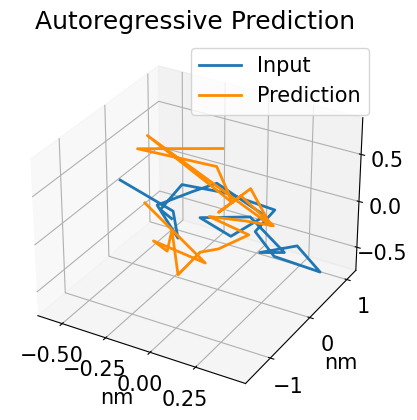

In [ ]:
autoreg_pred = np.array(torch.load('gnn_model/test_preds_9_no_reg.pt'))
print(autoreg_pred.shape)
autoreg_pred = autoreg_pred.reshape(-1,88,3)

print(autoreg_pred.shape)
autoreg_pred = autoreg_pred[:, 2:-2 ,:]
print(autoreg_pred.shape)

coords = test_struct[0]['coords']
print(coords.shape)




i_s = [4*i+1 for i in range(0,84//4)]
j = 47000
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(coords[:,2,0],
        coords[:,2,1],
        coords[:,2,2], lw=2, label='Input')
ax.plot(autoreg_pred[j,i_s,0],
        autoreg_pred[j,i_s,1],
        autoreg_pred[j,i_s,2], c='darkorange', lw=2, label='Prediction')
plt.title("Autoregressive Prediction")

ax.legend()
plt.xlabel('nm')
plt.ylabel('nm')
fig.savefig("noreg_test_plot.png")
plt.show()